<a href="https://colab.research.google.com/github/UMIDATA77/CCFD-with-ML-algorithms/blob/main/Plant_Disease_Classification_using_CNN_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub
vipoooool_new_plant_diseases_dataset_path = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')

print('Data source import complete.')


100%|██████████| 2.70G/2.70G [02:07<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


##  Project Overview
In this project, we aim to classify plant leaves into 38 categories (healthy vs. different diseases).  
The dataset contains:
- **70,295** training images  
- **17,572** validation images  
- **38 classes**

We will:
1. Preprocess images with data augmentation.  
2. Build a Convolutional Neural Network (CNN) using PyTorch.  
3. Train the model on the dataset.  
4. Evaluate accuracy and visualize performance.  

---


##  Import Libraries  

In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy

## Dataset Paths

In [20]:
# Paths
data_path = Path('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)')
image_path = data_path / 'New Plant Diseases Dataset(Augmented)'
train_dir = image_path / 'train'
valid_dir = image_path / 'valid'
test_dir = Path("/kaggle/input/new-plant-diseases-dataset/test")

## Data Augmentation & Transforms

In [21]:
# Data augmentation for training data
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),            # Resize to fixed size
    transforms.RandomHorizontalFlip(p=0.5),   # Flip horizontally
    transforms.RandomRotation(20),            # Rotate within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Random color changes
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))      # Normalize
])

# Validation transforms (no augmentation here)
valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply to datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)



## Load Dataset

In [22]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [23]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Classes: {train_data.classes}")

Number of training images: 70295
Number of validation images: 17572
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_lea

## Class Distribution

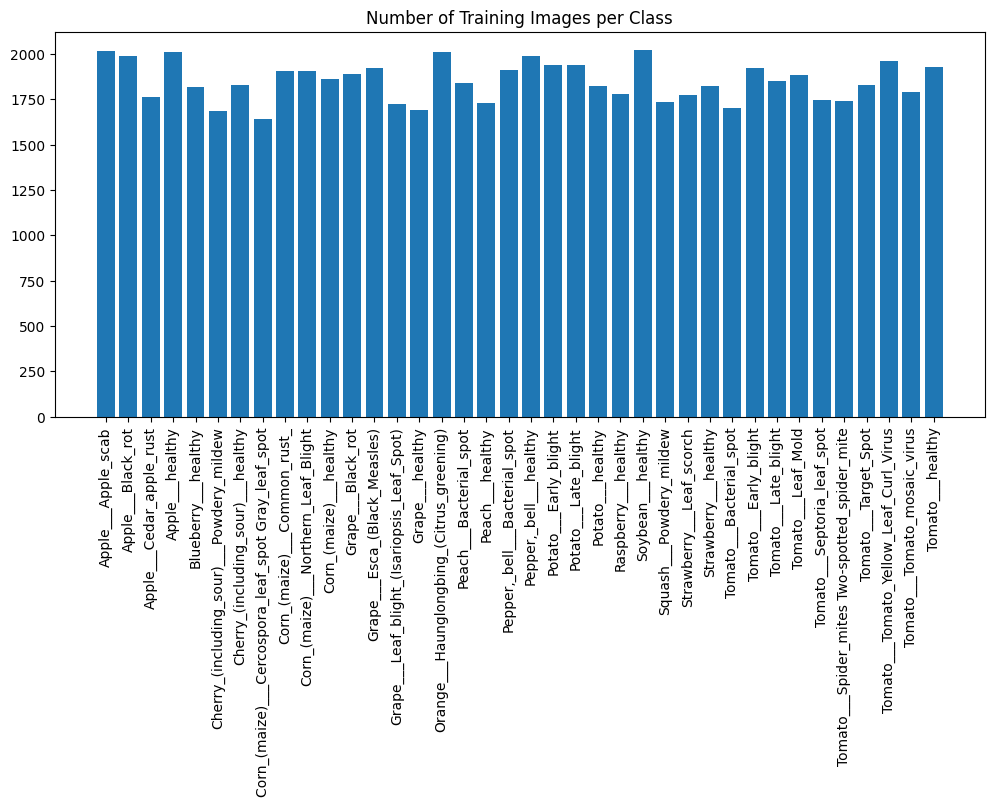

In [24]:
class_names = train_data.classes
class_counts = [len([p for p, _ in train_data.samples if class_names[train_data.targets[i]] == c])
                for i, c in enumerate(class_names)]

plt.figure(figsize=(12,5))
plt.bar(range(len(class_names)), [len([s for s in train_data.samples if s[1]==i]) for i in range(len(class_names))])
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.title("Number of Training Images per Class")
plt.show()


## Show Sample Images

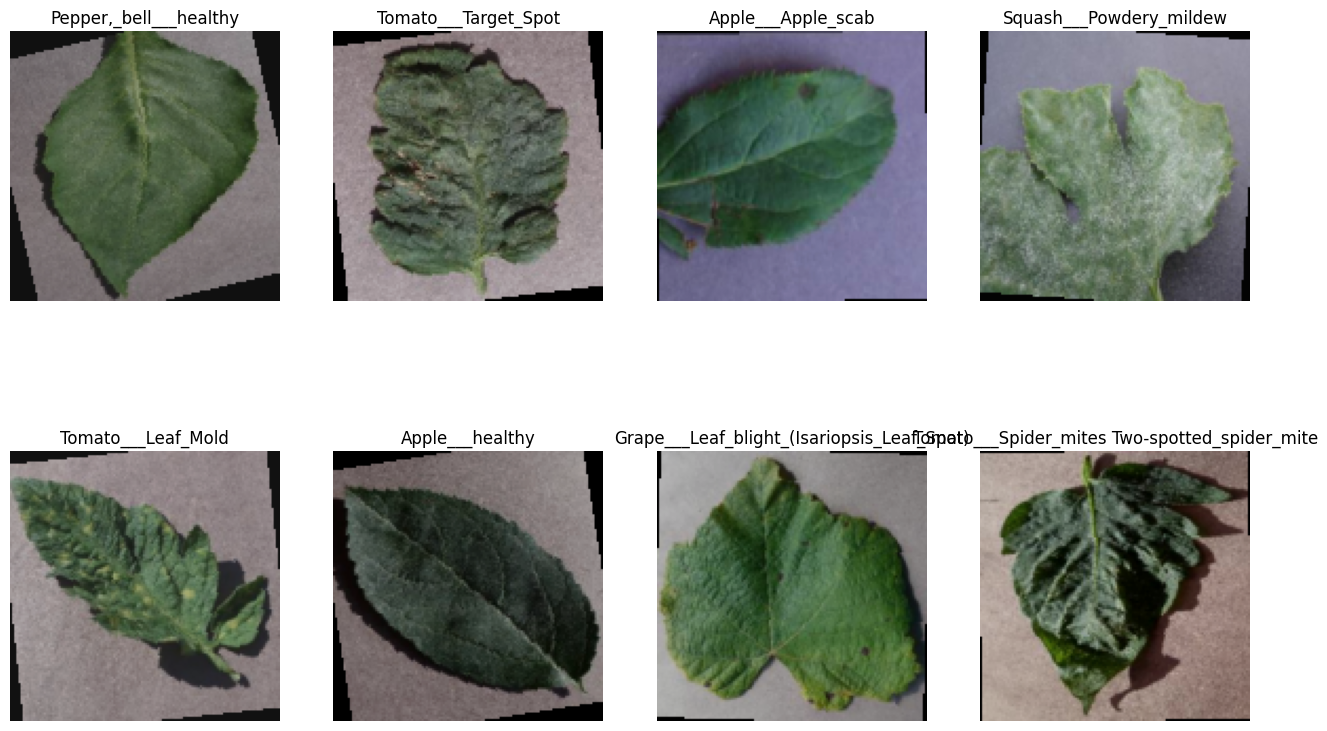

In [27]:
# Show sample images
def imshow(img, title):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get random batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show 8 images
plt.figure(figsize=(16, 10))
for idx in range(8):
    plt.subplot(2, 4, idx+1)
    imshow(images[idx], class_names[labels[idx]])
plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Code Implementation with PyTorch

This project is implemented using PyTorch, a popular deep learning framework. The code is organized into the following key segments:

In [32]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
patience = 5
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # ------- Training -------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # ------- Validation -------
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(valid_loader)

    #  history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ------- Model Checkpoint -------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print("  Best model updated and saved!")
        early_stop_counter = 0  # reset early stopping
    else:
        early_stop_counter += 1


    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # ------- Early Stopping -------
    if early_stop_counter >= patience:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break


# Load best weights
model.load_state_dict(best_model_wts)
print(f" Training Finished. Best Val Acc: {best_val_acc:.2f}%")

  Best model updated and saved!
Epoch [1/10] Train Loss: 1.8504 | Val Loss: 0.9279 | Train Acc: 45.80% | Val Acc: 71.51%
  Best model updated and saved!
Epoch [2/10] Train Loss: 1.2156 | Val Loss: 0.6627 | Train Acc: 62.71% | Val Acc: 80.03%
  Best model updated and saved!
Epoch [3/10] Train Loss: 1.0153 | Val Loss: 0.5335 | Train Acc: 68.55% | Val Acc: 83.89%
  Best model updated and saved!
Epoch [4/10] Train Loss: 0.8639 | Val Loss: 0.4421 | Train Acc: 73.31% | Val Acc: 86.30%
  Best model updated and saved!
Epoch [5/10] Train Loss: 0.7806 | Val Loss: 0.3987 | Train Acc: 75.85% | Val Acc: 87.28%
  Best model updated and saved!
Epoch [6/10] Train Loss: 0.7165 | Val Loss: 0.3301 | Train Acc: 77.89% | Val Acc: 89.35%
  Best model updated and saved!
Epoch [7/10] Train Loss: 0.6729 | Val Loss: 0.3154 | Train Acc: 78.96% | Val Acc: 89.49%
  Best model updated and saved!
Epoch [8/10] Train Loss: 0.6210 | Val Loss: 0.3127 | Train Acc: 80.54% | Val Acc: 90.01%
  Best model updated and saved!


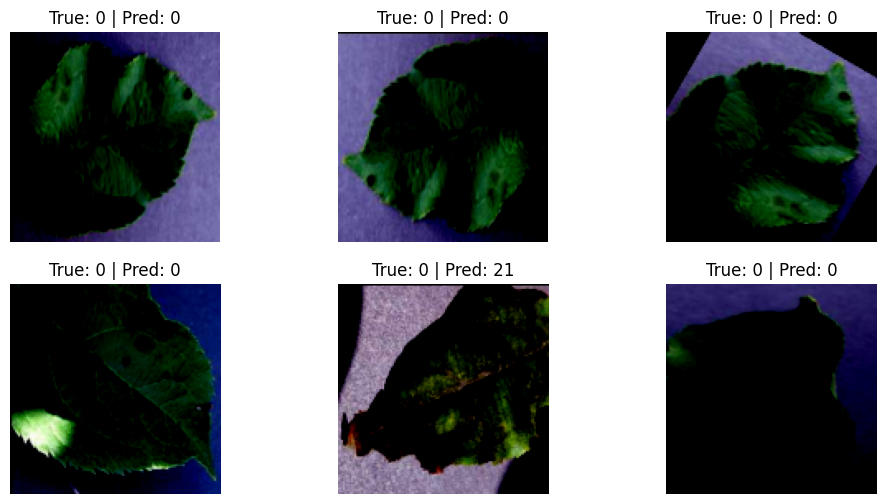

In [34]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # normalize
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Get a batch from validation loader
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


# Predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    title = f"True: {labels[i].item()} | Pred: {preds[i].item()}"
    imshow(images[i].cpu(), title)

plt.show()

# Confusion Matrix
# (Code for Confusion Matrix is in a separate cell)

# Plot Loss curves


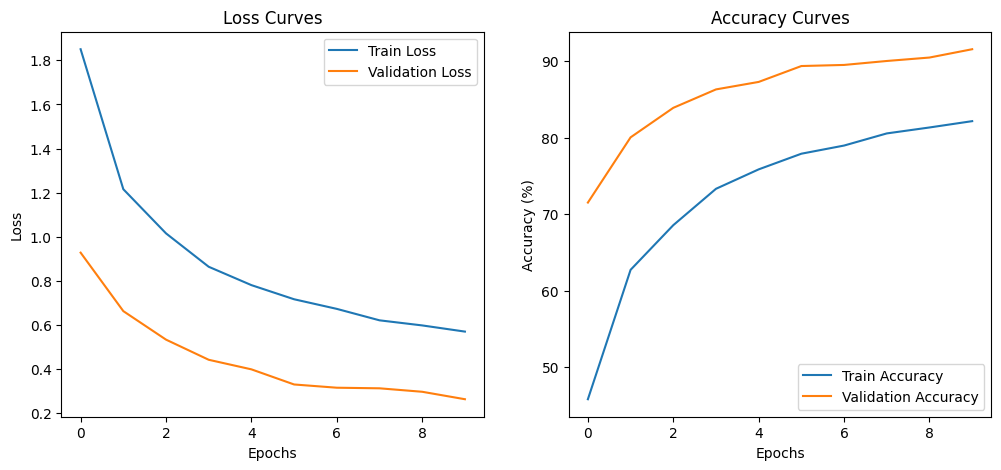

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Plot Accuracy curves
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curves")
plt.legend()

plt.show()

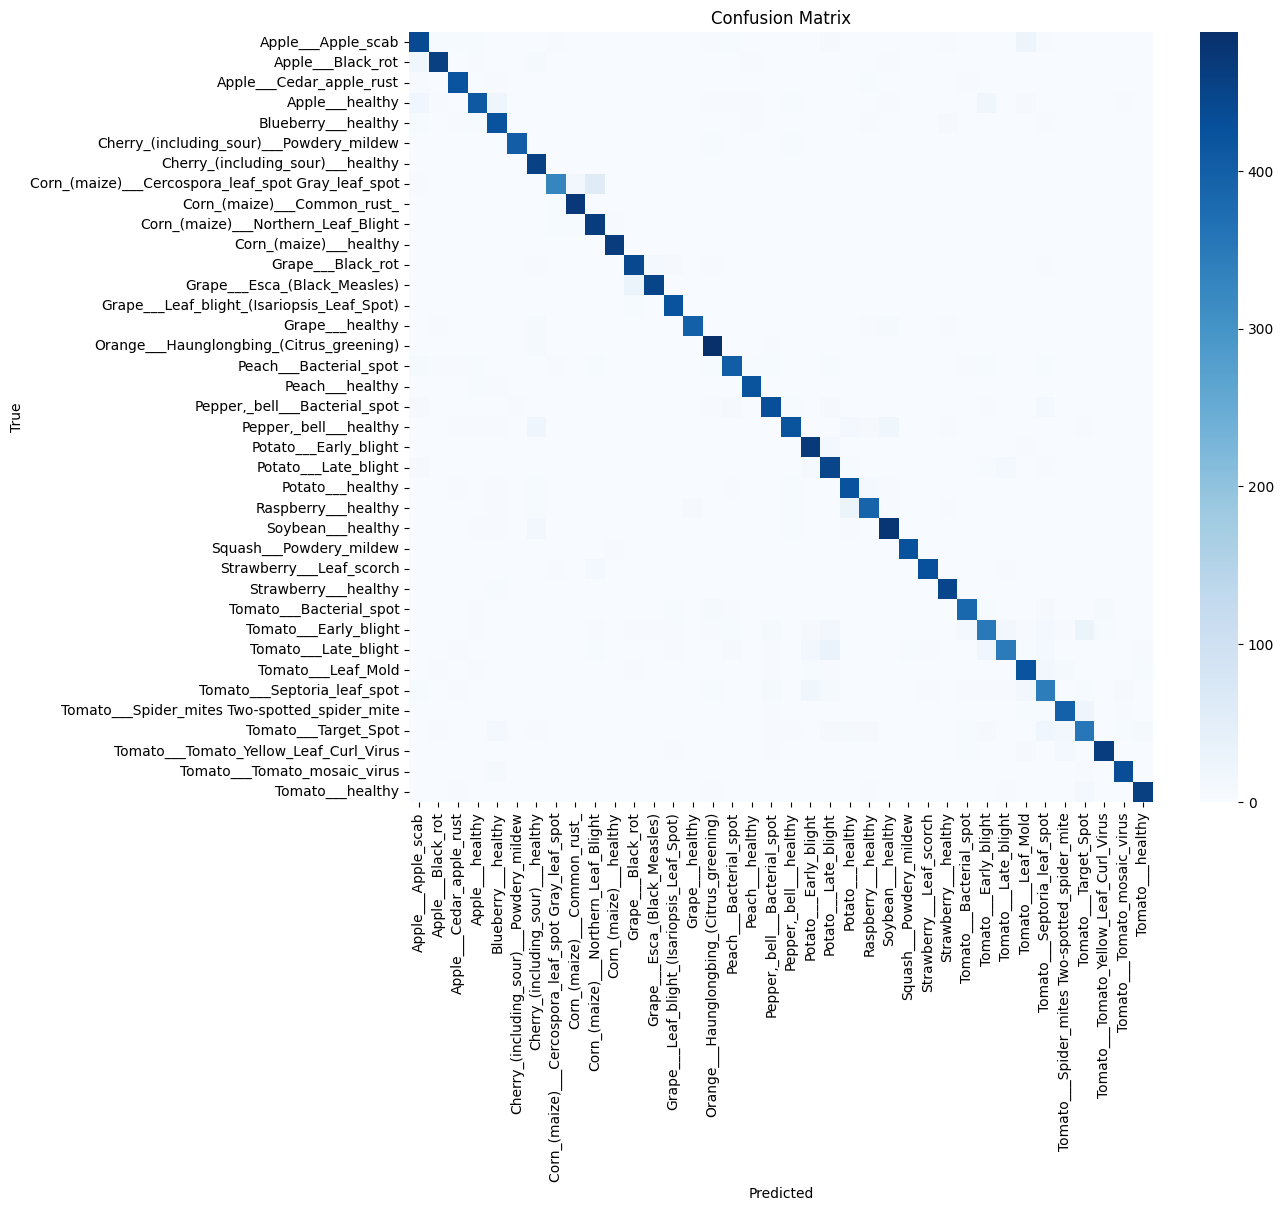

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and labels for the validation set
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = valid_loader.dataset.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [39]:
import torchvision.models as models

# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Get the number of input features for the last fully connected layer
num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one
# The number of output features should be the number of classes in your dataset
num_classes = len(train_data.classes)  # Assuming train_data is your training dataset
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the appropriate device
model = model.to(device)

print("ResNet18 model loaded and modified successfully.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


ResNet18 model loaded and modified successfully.


In [40]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
patience = 5
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # ------- Training -------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # ------- Validation -------
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(valid_loader)

    #  history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ------- Model Checkpoint -------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print("  Best model updated and saved!")
        early_stop_counter = 0  # reset early stopping
    else:
        early_stop_counter += 1


    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # ------- Early Stopping -------
    if early_stop_counter >= patience:
        print(f"⏹ Early stopping at epoch {epoch+1}")
        break


# Load best weights
model.load_state_dict(best_model_wts)
print(f" Training Finished. Best Val Acc: {best_val_acc:.2f}%")

  Best model updated and saved!
Epoch [1/10] Train Loss: 0.4055 | Val Loss: 0.1960 | Train Acc: 87.34% | Val Acc: 93.92%
  Best model updated and saved!
Epoch [2/10] Train Loss: 0.1918 | Val Loss: 0.1643 | Train Acc: 93.91% | Val Acc: 95.05%
  Best model updated and saved!
Epoch [3/10] Train Loss: 0.1421 | Val Loss: 0.0760 | Train Acc: 95.40% | Val Acc: 97.55%
  Best model updated and saved!
Epoch [4/10] Train Loss: 0.1168 | Val Loss: 0.0603 | Train Acc: 96.16% | Val Acc: 98.04%
Epoch [5/10] Train Loss: 0.0987 | Val Loss: 0.0721 | Train Acc: 96.76% | Val Acc: 97.64%
Epoch [6/10] Train Loss: 0.0894 | Val Loss: 0.0634 | Train Acc: 97.09% | Val Acc: 97.99%
Epoch [7/10] Train Loss: 0.0721 | Val Loss: 0.0689 | Train Acc: 97.67% | Val Acc: 97.93%
  Best model updated and saved!
Epoch [8/10] Train Loss: 0.0687 | Val Loss: 0.0412 | Train Acc: 97.79% | Val Acc: 98.69%
Epoch [9/10] Train Loss: 0.0582 | Val Loss: 0.0572 | Train Acc: 98.16% | Val Acc: 98.27%
Epoch [10/10] Train Loss: 0.0597 | Val 

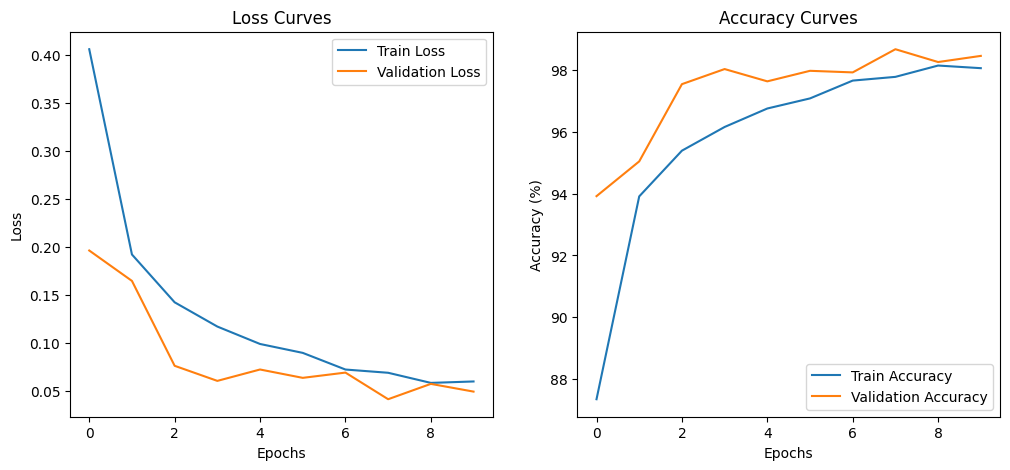

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Plot Accuracy curves
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curves")
plt.legend()

plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Get all predictions and labels for the validation set
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate and print metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Print classification report for more detailed metrics per class
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

Accuracy: 0.9869
Precision (weighted): 0.9871
Recall (weighted): 0.9869
F1 Score (weighted): 0.9868

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      0.99       504
                                 Apple___Black_rot       0.99      0.99      0.99       497
                          Apple___Cedar_apple_rust       0.99      1.00      1.00       440
                                   Apple___healthy       0.98      0.99      0.99       502
                               Blueberry___healthy       1.00      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.93      0.96       410
                       Corn_(maize)___Common_ru

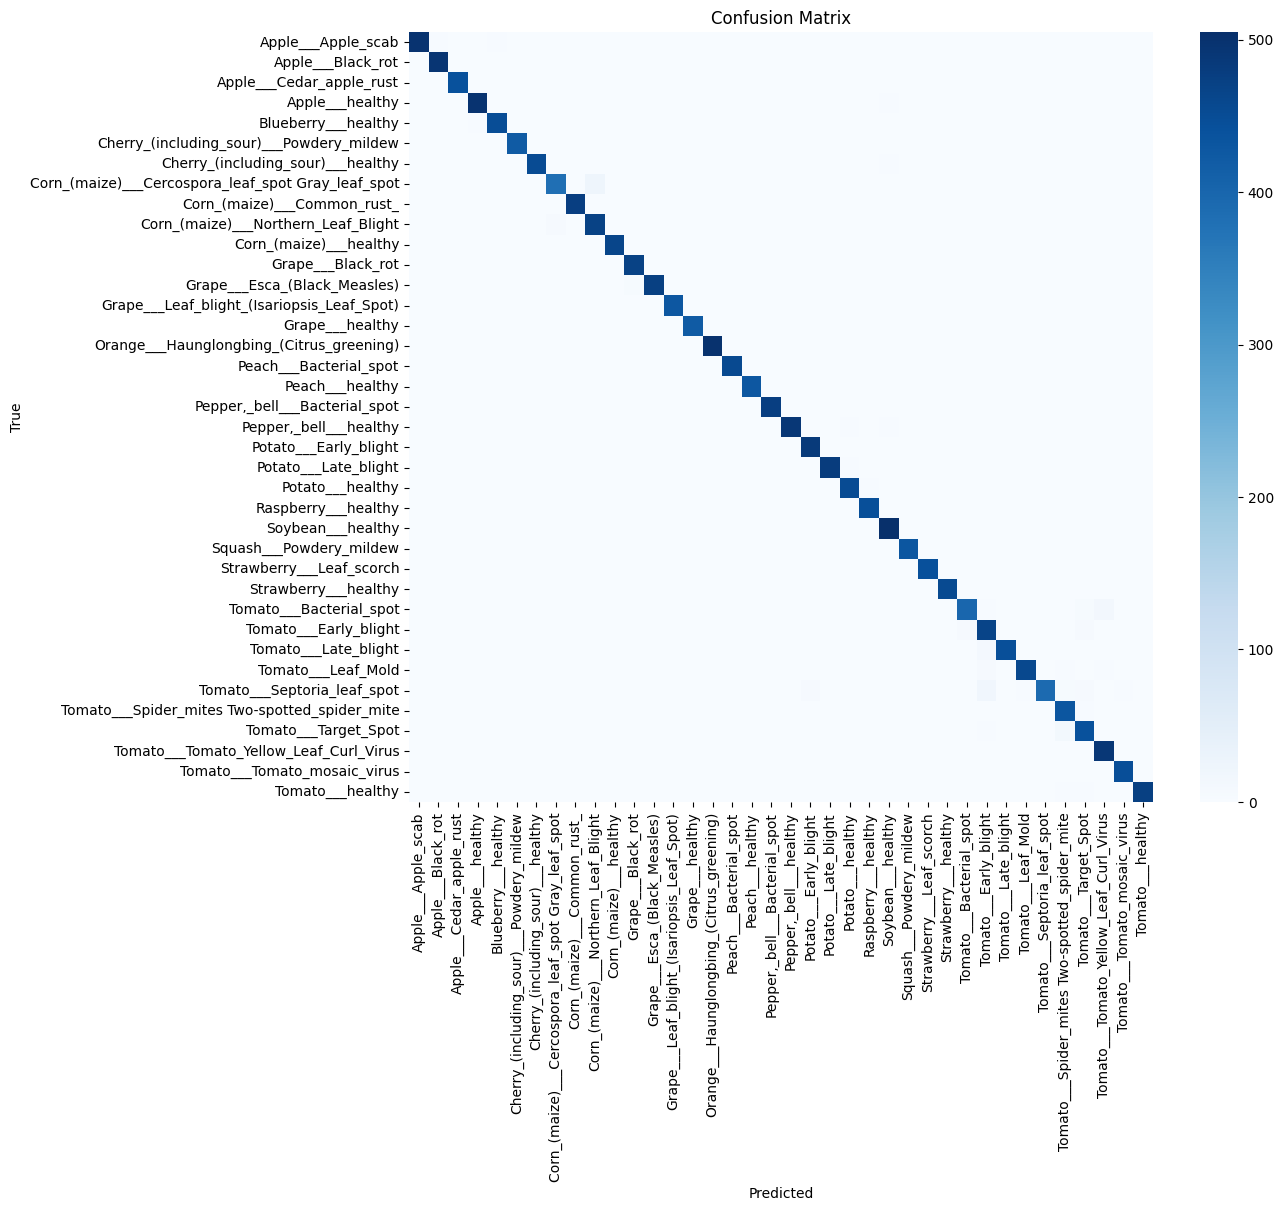

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get all predictions and labels for the validation set
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
classes = valid_loader.dataset.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [44]:
# Save the trained model
torch.save(model.state_dict(), 'plant_disease_resnet18_model.pth')
print("Trained model saved as 'plant_disease_resnet18_model.pth'")

Trained model saved as 'plant_disease_resnet18_model.pth'
